# Исследование рынка компьютерных игр

В рамках данного исследования наша задача состоит в анализе исторических данных о продажах компьютерных игр по всему миру. В нашем распоряжении информация о продажах, оценках пользователей и экспертов, а также о жанрах и платформах, для которых созданы игры. Данные представлены до 2016 года. Наша цель - выявить закономерности, которые могут определить успешность игры в 2017 году.

Для выполнения цели составим план работ:
1. Загрузка и предобработка данных
2. Исследовательский анализ данных
3. Составление портрета пользователя каждого региона
4. Проверка гипотез

Приступим к исследованию!

## Загрузка и предобработка данных

### Загрузка данных

Для начала импортируем нужные библиотеки.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

Теперь загрузим данные в переменную `data` и изучим основную информацию о них.

In [2]:
try:
    data = pd.read_csv('/Users/macbook/practicum/projects/games_project/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
15919,Oshiri Kajiri Mushi no Rhythm Lesson DS: Kawai...,DS,2008.0,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
1738,Destruction Derby 2,PS,1996.0,Racing,0.65,0.44,0.00,0.08,NaN,NaN,NaN
3689,Are You Smarter than a 5th Grader? Make the Grade,Wii,2008.0,Misc,0.50,0.00,0.00,0.04,NaN,tbd,E
15081,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,0.00,0.00,0.02,0.00,NaN,NaN,NaN
10587,Help Wanted: 50 Wacky Jobs,Wii,2008.0,Simulation,0.06,0.03,0.00,0.01,65.0,7,E10+
10902,Retro Game Challenge (US sales),DS,2007.0,Action,0.09,0.00,0.00,0.00,NaN,NaN,NaN
3229,Madden NFL 07,GC,2006.0,Sports,0.48,0.13,0.00,0.02,82.0,9.2,E
14820,Bleach: Soul Carnival 2,PSP,2009.0,Fighting,0.00,0.00,0.03,0.00,NaN,NaN,NaN
8253,ESPN Final Round Golf 2002,GBA,2001.0,Sports,0.12,0.05,0.00,0.00,70.0,tbd,E
5542,Major League Baseball 2K6,XB,2006.0,Sports,0.24,0.07,0.00,0.01,71.0,5.7,E


In [5]:
data['Year_of_Release'].min()

1980.0

In [6]:
data['Year_of_Release'].max()

2016.0

Датафрейм содержит информацию о более чем 16 тысячах игр, выпущенных за период с 1980 по 2016 год. При этом мы знаем, что данные за 2016 год могут быть неполными.

Количество ненулевых значений в столбцах различается - значит, в данных присутствуют пропуски. Изучим их в ходе предобработки данных.

Согласно документации к данным столбцы содержат следующую информацию:

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию

[ESRB](https://www.esrb.org/ratings-guide/) выделяет следующие возрастные рейтинги:
* EC (Early childhood) — Для детей младшего возраста

Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.

* E (Everyone) - Для всех

Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально обозначался как K-A (Kids to Adults).

* E10+ (Everyone 10+) — Для всех от 10 лет и старше

Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.

* T (Teen) -  Для подростков

Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

* M (Mature 17+) - Для взрослых

Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

* AO (Adults Only) - Только для взрослых

Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.

* RP (Rating Pending) - Рейтинг ожидается

Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный "рейтинг" используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

### Предобработка данных

#### Переименование столбцов

Для удобства работы с данными приведем названия столбцов к нижнему регистру.

In [7]:
data.columns = data.columns.str.lower()

Убедимся в том, что столбцы были успешно переименованы.

In [8]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Изменение типов данных

Приведем данные к соотвествующему типу.

* тип данных в столбце `year_of_release` необходимо заменить на `int`, так как он содержит года, которые могут быть представлены только целыми числами:

In [9]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

Мы не приводим год выпуска к типу данных `datetime`, так как информация о дате выпуска игры неполная и содержит только год.

* тип данных в столбце `user_score` необходимо заменить на `float`, так как он содержит вещественные значения от 0 до 10:

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Также на данном шаге мы заменили все ошибки в процессе приведения данных на пропущенные значения. Такой метод обработки ошибок был выбран, так как не вещественные значения содержали аббревиатуру `tbd`, которая означает to be determined. То есть на момент формирования датафрейма значения оценки пользователей еще не были известны для определенных игр.

Проверим тип данных после применения изменений.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


#### Работа с пропусками

Для начала определим, в каких столбцах есть пропуски и сколько их.

In [12]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

* название игры и жанр:

In [13]:
data.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски в данных столбцах относятся к одним и тем же строкам. Причиной данных пропусков может быть техническая ошибка.

Так как таких строк мало и для замены пропусков нет очевидной замены, исключим их из датафрейма.

In [14]:
data = data.query('name.notna()')

* год выпуска:

Пропусков в годах выпуска немного. Скорее всего, они вызваны человеческим фактором.

Некоторые игры имеют год выпуска в своих названиях. Мы можем вычленить эти года из названий и заполнить пропуски в соответствующем столбце. При этом проведем проверку, что полученный год находится между 1980 и 2016 годами, чтобы исключить аномалии из-за игр с историческими датами в названии (например, Метро 2033).

In [15]:
data.loc[:, 'year_from_name'] = data['name'].str.findall(r'\d{4}').apply(lambda x: int(x[0]) if len(x) > 0 and '1980' <= x[0] <= '2016' else np.NaN)
data.loc[(data['year_of_release'].isna()) & (data['year_from_name'].notna()), 'year_of_release'] = data['year_from_name']
data.drop('year_from_name', axis=1, inplace=True) #удалим столбец после использования, чтобы не путаться в них

Оставшиеся строки с пропущенным годом выпуска также исключим из датафрейма в силу их немногочисленности и остутствия очевидных замен.

In [16]:
data = data.query('year_of_release.notna()')

* оценки критиков и пользователей:

Для большинства игр остутствуют оценки критиков и/или пользователей. Это может быть связано с тем, что игр действительно выходит очень много и не для всех критики и пользователи уделяют время, чтобы поставить оценку.

Заполним пропуски средними оценками этих же игр, но выпущенных для других платформ, где это возможно. Остальные пропущенные значения оставим как есть, так как их слишком много, чтобы их исключать, но очевидно замены для них нет.

In [17]:
data.loc[:, 'critic_score'] = data.groupby('name')['critic_score'].transform(lambda x: x.fillna(x.mean()))

In [18]:
data.loc[:, 'user_score'] = data.groupby('name')['user_score'].transform(lambda x: x.fillna(x.mean()))

* рейтинг ESRB:

Пропуски в возрастном рейтинге могут быть вызваны как тем, что у ESRB как и у критиков нет возможности оценить все выпущенные игры, как и тем, что организация появилась только в 1994 году, в то время как в нашем датафрейме есть игры, выпущенные гораздо раньше.

Так как пропусков много и для них нет очевидной замены, оставим пропущенные значения как есть.

Проверим клочество пропусков в датафрейме после внесения изменений.

In [19]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7522
user_score         7921
rating             6682
dtype: int64

#### Обработка дубликатов

Проверим датафреймы на наличие дубликатов.

In [20]:
data.duplicated().sum()

0

Проверка показала, что в датафрейме нет дубликатов.

#### Расчет суммарных продаж

Рассчитаем суммарные продажи по всем регионам.

In [21]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

### Распределение количества выпущенных игр по годам

Построим распределение количества выпущенных игр за каждый год, чтобы выделить период с наиболее релевантными для анализа данными.

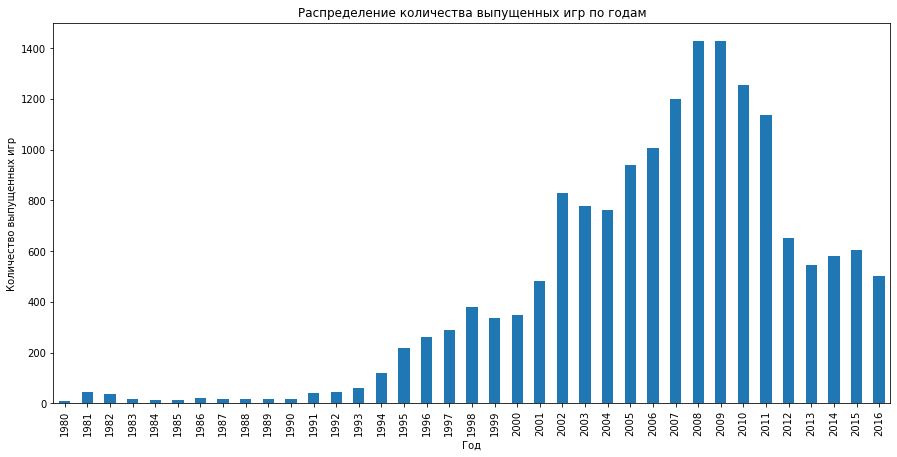

In [22]:
games_by_years = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
#построим сводную таблицу для построения распределения

games_by_years.plot(kind='bar', figsize=(15,7))
plt.title('Распределение количества выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество выпущенных игр')
plt.legend().remove()
plt.show()

Из графика выше можно сделать вывод о том, что в 90-х годах начался рост популярности компьютерных игр и она достигла своего пика в 2008-2009 годах, когда было выпущено около полутора тысяч игр.

Начиная с 2010 года производство игр стало сокращаться и в течение последних четырех лет выпускается около пятиста игр в год.

Так как нам нужно выявить закономерности, которые могут определить успешность игры в 2017 году, для анализа наиболее релевантными будут данные за 2012-2016 годы.

### Распределение продаж по платформам

Выделим плафтормы с наибольшими суммарными продажами и построим распределение продаж по годам, чтобы определить, за какой характерный срок появляются новые и исчезают старые платформы.

In [23]:
sales_by_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
sales_by_platforms.columns = ['total_sales']
sales_by_platforms.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


Для анализа выберем топ-6 платформ. Построим для них графики распределения продаж по годам.

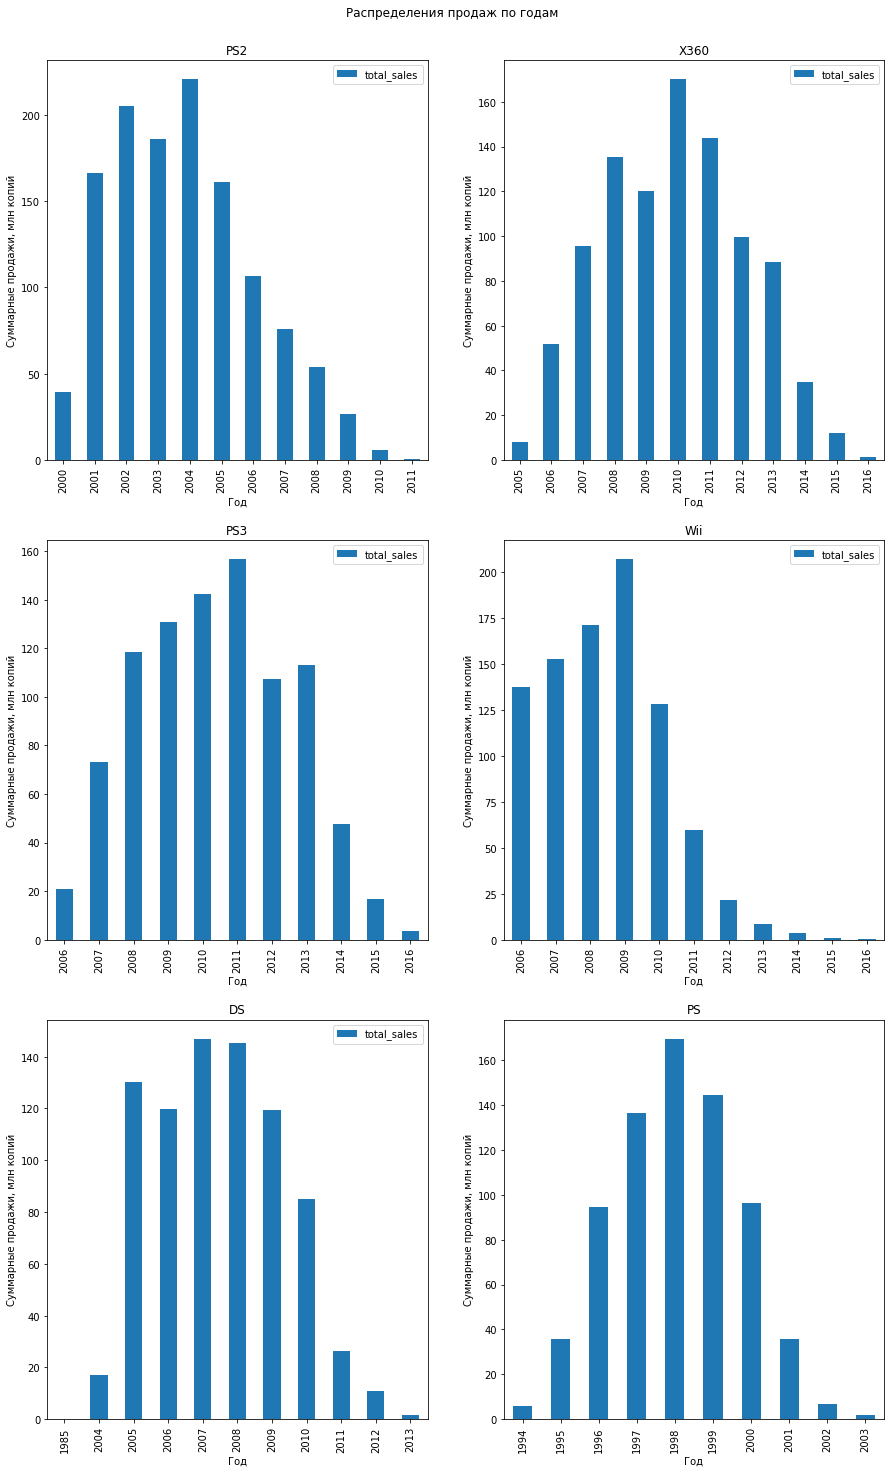

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 25))
fig.suptitle('Распределения продаж по годам', y=0.91)

data.loc[data['platform'] == 'PS2'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'PS2', ax=axs[0,0])
data.loc[data['platform'] == 'X360'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'X360', ax=axs[0,1])
data.loc[data['platform'] == 'PS3'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'PS3', ax=axs[1,0])
data.loc[data['platform'] == 'Wii'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'Wii', ax=axs[1,1])
data.loc[data['platform'] == 'DS'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'DS', ax=axs[2,0])
data.loc[data['platform'] == 'PS'].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', title = 'PS', ax=axs[2,1])


for ax in axs.flat:
    ax.set(xlabel='Год', ylabel='Суммарные продажи, млн копий')

plt.legend().remove()
plt.show()

Исходя из графиков можно сделать вывод о том, что жизненный цикл платформы составляет около 10 лет. Соответственно для исследования нужно выбирать игры на тех платформах, которые появились не менее 10 лет назад.

### Выбор актуальных для исследования периода и платформ

Сформируем датафрейм, на основе которого будем проводить исследование.

Для начала выделим актуальный период.

In [25]:
relevant_data = data.copy().query('year_of_release >= 2012')

In [26]:
relevant_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2887 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2887 non-null   object 
 1   platform         2887 non-null   object 
 2   year_of_release  2887 non-null   Int64  
 3   genre            2887 non-null   object 
 4   na_sales         2887 non-null   float64
 5   eu_sales         2887 non-null   float64
 6   jp_sales         2887 non-null   float64
 7   other_sales      2887 non-null   float64
 8   critic_score     1693 non-null   float64
 9   user_score       1743 non-null   float64
 10  rating           1612 non-null   object 
 11  total_sales      2887 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 296.0+ KB


В выбранном датафрейме около трех тысяч строк - достаточно для проведения углубленного анализа.

Теперь изучим платформы, игры для которых выпускались в выбранном нами периоде.

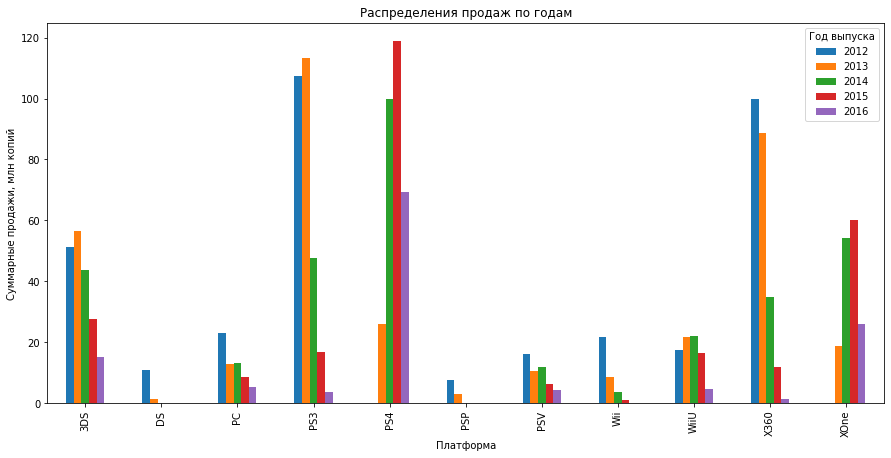

In [27]:
relevant_data.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=[15, 7])

plt.title('Распределения продаж по годам')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи, млн копий')
plt.legend(title='Год выпуска')

plt.show()

На основе граифка можно сделать следующие выводы по платформам:
* 3DS

Начиная с 2013 года продажи игр для 3DS начали падать, тем не менее данная платформа остается в топ-3 по количеству проданных копий в 2016 году.

* DS

Продажи игр для DS остаются весьма незначительными последние 3 года.

* PC

Несмотря на снижающийся спрос на игры для PC, продажи остаются значительными в 2016 году. 

* PS3

Продажи игр для PS3 резко начали падать, начиная с 2014 года. Это, конечно, связано с успешным выпуском PS нового поколения - PS4.

* PS4

Несмотря на снижение уровня продаж в 2016 году, PS4 остается абсолютным лидером по количеству проданных копий.

* PSP

Игры для PSP, также как и для DS, продаются сравнительно небольшим тиражом последние 3 года.

* PSV

Спрос на игры для PSV снижается последние три года, но остается значительным в 2016 году.

* Wii

По аналогии с PS, продажи игр на Wii резко сократились с 2013 года с выпуском консоли нового поколения - WiiU.

* WiiU
Продажи игр для WiiU начали снижаться в 2015 году, но спрос все еще остается значительным в 2016 году.

* X360

Игры для X360 также стали продаваться меньшим тиражом после выпсука консоли следующего поколения в 2013 - XOne. 

* XOne

Также не смотря на снижение продаж в 2016 году, платформа остается на втором месте по количеству проданных копий игр.


Исходя из анализа платформ выше мы можем выделить наиболее перcпективные:
1. PS4
2. XOne
3. 3DS
4. PC
5. WiiU

In [28]:
top_platforms = ['PS4', 'XOne', '3DS', 'PC', 'WiiU']

### Анализ суммарных продаж на перспективных платформах

Изучим разброс суммарных продаж по выбранным нами платформам, чтобы оценить и спрогнозировать средние показатели для каждой платформы.

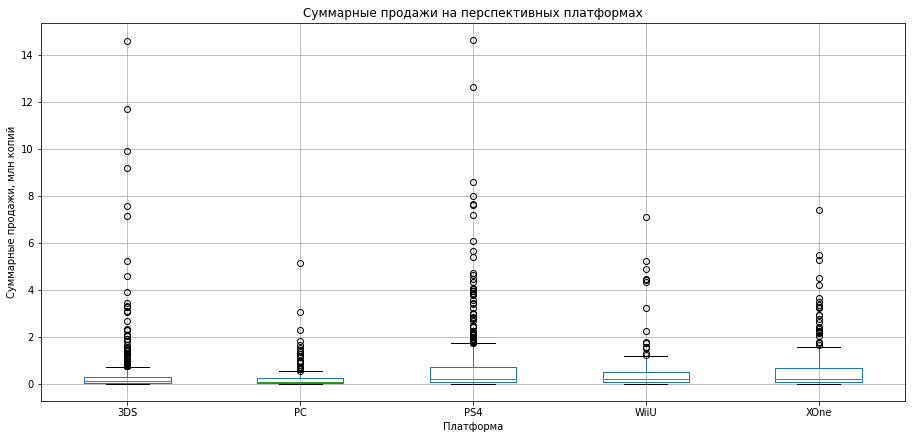

In [29]:
relevant_data.query('platform.isin(@top_platforms)').boxplot('total_sales', by='platform', figsize=[15, 7])

plt.title('Суммарные продажи на перспективных платформах')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи, млн копий')

plt.show()

Из графика выше можно сделать вывод о том, что стандартный тираж игр составляет около миллиона копий для DS и PC и 1.5-2 миллиона для PS4, WiiU и XOne.

При этом мы видим, что сверхпопулярные игры зачастую выпускаются для 3DS и PS4 с максимальным тиражом в 15 миллионов копий. Игры для WiiU и XOne не превышают тираж в 8 миллионов копий, а для PC - в 6 миллионов копий.

### Влияние оценок на продажи

Изучим влияние оценок критиков и пользователей на продажи на примере самой популярной платформы - PS4.

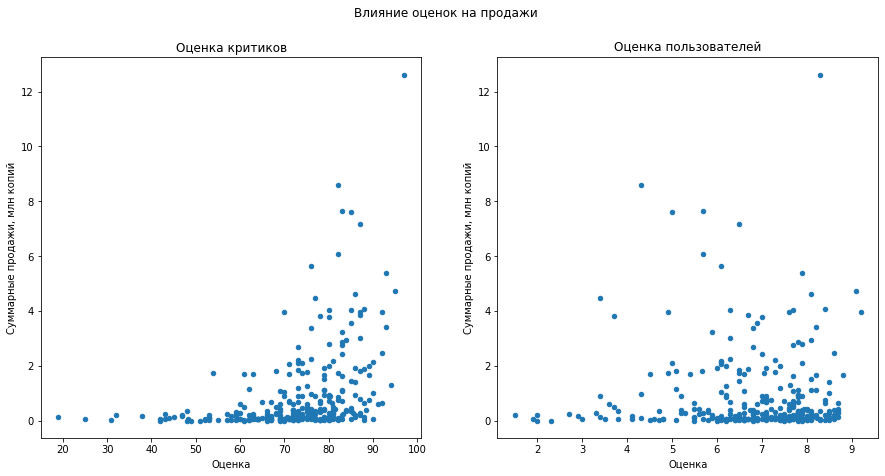

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle('Влияние оценок на продажи')

relevant_data.loc[relevant_data['platform'] == 'PS4'].plot(x='critic_score', y='total_sales', kind='scatter',\
                                                           title='Оценка критиков', ax=axs[0])
relevant_data.loc[relevant_data['platform'] == 'PS4'].plot(x='user_score', y='total_sales', kind='scatter',\
                                                           title='Оценка пользователей', ax=axs[1])
for ax in axs.flat:
    ax.set(ylabel='Суммарные продажи, млн копий', xlabel='Оценка')

plt.show()

In [31]:
relevant_data.loc[relevant_data['platform'] == 'PS4']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'PS4']['critic_score'])

0.39155120045082015

In [32]:
relevant_data.loc[relevant_data['platform'] == 'PS4']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'PS4']['user_score'])

-0.021612493200478526

Графики выше демонстрируют прямую связь между оценками критиков и суммарными продажами игр, и практически отсутствие связи между оценками пользователей и суммарными продажами.

Эту закономерность подтверждают коэффициенты корреляции между параметрами: 0.39 и -0.02, соответственно.

Следовательно оценки критиков имеют определенное влияние на успешность игры с точки зрения продаж, а вот оценки пользователей - нет.

Проверим, насколько данный вывод распространяется на другие релевантные платформы:

* XOne:

In [33]:
relevant_data.loc[relevant_data['platform'] == 'XOne']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'XOne']['critic_score'])

0.37398972351240567

In [34]:
relevant_data.loc[relevant_data['platform'] == 'XOne']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'XOne']['user_score'])

-0.09402749243006256

Для XOne наблюдается схожая связь между оценками критиков и пользователей и суммарными продажами.

* 3DS:

In [35]:
relevant_data.loc[relevant_data['platform'] == '3DS']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == '3DS']['critic_score'])

0.29150875716625446

In [36]:
relevant_data.loc[relevant_data['platform'] == '3DS']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == '3DS']['user_score'])

0.21418790254856826

Стоит отметить, что для 3DS оценки критиков имеют меньше влияния на суммарные продажи по сравнению с предыдущими двумя платформами, а вот оценки пользователей - наоборот, больше.

Но все же коэффициенты небольшие и указывают скорее на слабую связь между оценками критиков и пользователей и суммарными продажами.

* PC:

In [37]:
relevant_data.loc[relevant_data['platform'] == 'PC']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'PC']['critic_score'])

0.2322754824980256

In [38]:
relevant_data.loc[relevant_data['platform'] == 'PC']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'PC']['user_score'])

-0.1262508450814366

Связь между оценками критиков и пользователей и суммарными продажами для PC подчинаяется той же закономерности, что и для 3DS.

* WiiU:

In [39]:
relevant_data.loc[relevant_data['platform'] == 'WiiU']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'WiiU']['critic_score'])

0.32749655500689184

In [40]:
relevant_data.loc[relevant_data['platform'] == 'WiiU']['total_sales']\
    .corr(relevant_data.loc[relevant_data['platform'] == 'WiiU']['user_score'])

0.3668819759743242

Для WiiU оценки пользователей имеют чуть большее влияние на суммарные продажи, чем оценки критиков. Но опять же это влияние не является решающим для успешности игры с точки зрения продаж.

Исходя из проведенного анализа корреляции оценок критиков и пользователей и суммарных продаж для релевантных платформ, мы можем сделать вывод, что нет единой закономерности, которой подчиняется эта связь. Для каждой платформы существует своя закономерность.

Однако для всех платформ эта связь достаточно слабая и не имеет решающего влияния на успешность игры с точки зрения продаж.

### Распределение продаж по жанрам

Проанализируем распределение продаж по жанрам и изучим прибыльность различных жанров.

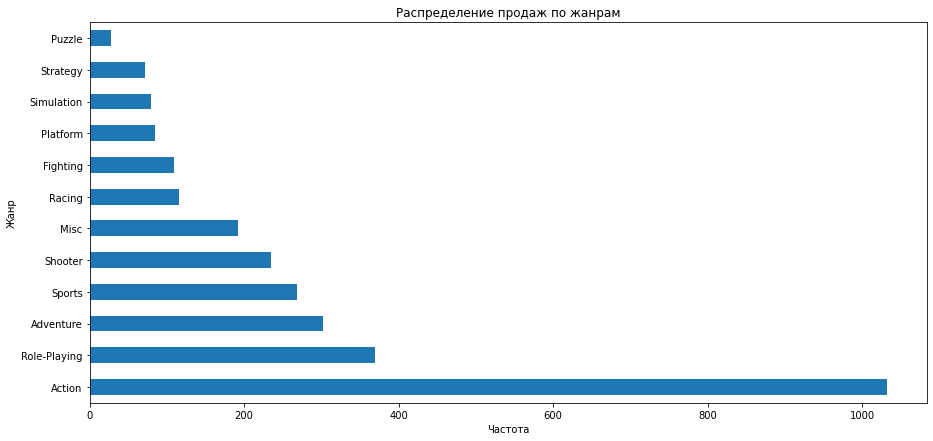

In [41]:
relevant_data['genre'].value_counts().plot(kind='barh', figsize=(15,7))

plt.title('Распределение продаж по жанрам')
plt.xlabel('Частота')
plt.ylabel('Жанр')

plt.show()

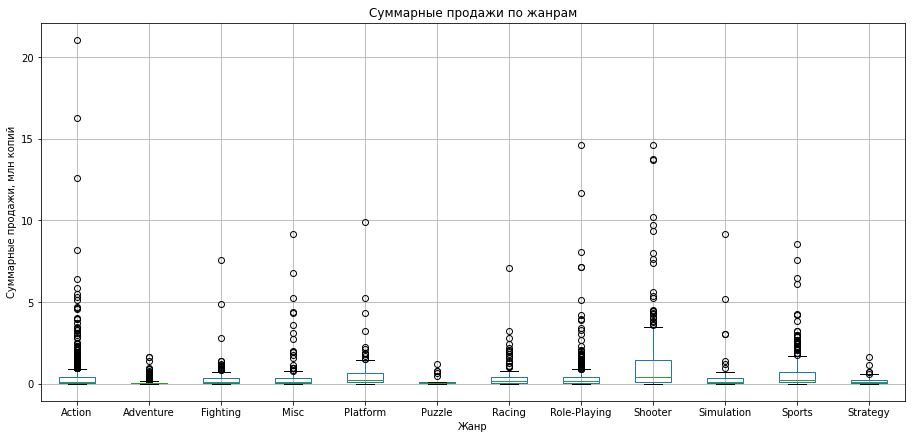

In [42]:
relevant_data.boxplot('total_sales', by='genre', figsize=[15, 7])

plt.title('Суммарные продажи по жанрам')
plt.suptitle('')
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи, млн копий')

plt.show()

In [43]:
relevant_data.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,1032.0,0.427781,1.165941,0.01,0.030,0.120,0.3900,21.05
Adventure,302.0,0.097450,0.208237,0.01,0.020,0.030,0.0775,1.66
Fighting,109.0,0.408165,0.910385,0.01,0.060,0.130,0.3600,7.55
Misc,192.0,0.442917,1.081047,0.01,0.030,0.120,0.3375,9.18
Platform,85.0,0.717647,1.364413,0.01,0.090,0.210,0.6600,9.90
Puzzle,28.0,0.174643,0.305438,0.01,0.020,0.045,0.1025,1.19
Racing,115.0,0.465217,0.888664,0.01,0.050,0.140,0.4200,7.09
Role-Playing,370.0,0.521081,1.315937,0.01,0.060,0.140,0.4075,14.60
Shooter,235.0,1.296723,2.251662,0.01,0.135,0.440,1.4800,14.63


Исходя из графиков выше мы можем сделать вывод о том, что самый популярный жанр с точки зрения количества выпсукаемых игр - это Action. Более трети игр в нашей выборке относятся к данному жанру.

При этом, с точки зрения количества проданных копий самый прибыльный жанр - это Shooter. Игры данного жанра в среднем расходятся тиражом в более миллиона копий.

Если обратить внимание на сверхприбыльные игры, то тут также лидирует жанр Action - максимальный тираж одной из игр составил более 21 миллиона копий. Второе место делят жанры Shooter и Role-Playing - около 14.6 миллионов копий. Третье место за жанром Platform - почти 10 миллионов копий.

## Составление портрета пользователя для каждого региона

Изучим самые популярные платформы и жанры для пользователей из каждого региона, а также влияние рейтинга ESRB на продажи в каждом регионе.

### Северная Америка

In [44]:
na_sales_by_platforms = relevant_data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
na_sales_by_platforms.columns = ['na_sales']
na_sales_by_platforms['%'] = na_sales_by_platforms['na_sales'] / na_sales_by_platforms['na_sales'].sum() * 100
na_sales_by_platforms.sort_values(by='%', ascending=False)

,na_sales,%
platform,,
X360,140.05,23.695921
PS4,108.74,18.398389
PS3,103.38,17.491498
XOne,93.12,15.755545
3DS,55.31,9.358239
WiiU,38.10,6.446373
PC,19.18,3.245182
Wii,17.45,2.952473
PSV,10.98,1.857774


Наиболее популярными платформами в Северной Америке являются X360 (24% проданных копий приходится на эту платформу), PS4 (18%) и PS3 (17%).

In [45]:
na_sales_by_genre = relevant_data.pivot_table(index='genre', values='na_sales', aggfunc='sum')
na_sales_by_genre.columns = ['na_sales']
na_sales_by_genre['%'] = na_sales_by_genre['na_sales'] / na_sales_by_genre['na_sales'].sum() * 100
na_sales_by_genre.sort_values(by='%', ascending=False)

,na_sales,%
genre,,
Action,177.90,30.099995
Shooter,144.77,24.494527
Sports,81.53,13.794562
Role-Playing,64.00,10.828554
Misc,38.19,6.461601
Platform,25.38,4.294198
Fighting,19.79,3.348392
Racing,17.22,2.913558
Adventure,8.92,1.509230


Больше всего копий игр было продано в жанрах Action (30%) и Shooter (24%).

In [46]:
na_sales_by_rating = relevant_data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
na_sales_by_rating.columns = ['na_sales']
na_sales_by_rating['%'] = na_sales_by_rating['na_sales'] / na_sales_by_rating['na_sales'].sum() * 100
na_sales_by_rating.sort_values(by='%', ascending=False)

,na_sales,%
rating,,
M,231.63,47.492414
E,114.37,23.449930
E10+,75.70,15.521201
T,66.02,13.536455


Абсолютное большинство проданных копий принадлежит к возрастному рейтингу "Для взрослых" - 47%.

#### Портрет пользователя

Пользователь из Новой Америки выбирает игры для таких платформ, как XOne, PS4 и PS3. Он/она предпочитает игры в жанре Action и Shooter. Наиболее часто он/она приобретатет игры с возрастным рейтингом "Для взрослых", что типично для предпочитаемых им/ей жанров.

### Европа

In [47]:
eu_sales_by_platforms = relevant_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
eu_sales_by_platforms.columns = ['eu_sales']
eu_sales_by_platforms['%'] = eu_sales_by_platforms['eu_sales'] / eu_sales_by_platforms['eu_sales'].sum() * 100
eu_sales_by_platforms.sort_values(by='%', ascending=False)

,eu_sales,%
platform,,
PS4,141.09,27.824561
PS3,106.86,21.074013
X360,74.52,14.696196
XOne,51.59,10.174138
3DS,42.64,8.409095
PC,38.01,7.496006
WiiU,25.13,4.955923
Wii,11.92,2.350760
PSV,11.36,2.240322


В Европе наибольшей популярностью пользуются PS4 (28% проданных копий приходится на эту платформу) и PS3 (21%).

In [48]:
eu_sales_by_genre = relevant_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
eu_sales_by_genre.columns = ['eu_sales']
eu_sales_by_genre['%'] = eu_sales_by_genre['eu_sales'] / eu_sales_by_genre['eu_sales'].sum() * 100
eu_sales_by_genre.sort_values(by='%', ascending=False)

,eu_sales,%
genre,,
Action,159.59,31.472972
Shooter,113.47,22.377581
Sports,69.09,13.625338
Role-Playing,48.53,9.570671
Racing,27.29,5.381900
Misc,26.32,5.190605
Platform,21.41,4.222297
Simulation,14.55,2.869426
Fighting,10.79,2.127911


Наиболее популярными жанрами по количеству проданных копий являются Action (31%) и Shooter (22%).

In [49]:
eu_sales_by_rating = relevant_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
eu_sales_by_rating.columns = ['eu_sales']
eu_sales_by_rating['%'] = eu_sales_by_rating['eu_sales'] / eu_sales_by_rating['eu_sales'].sum() * 100
eu_sales_by_rating.sort_values(by='%', ascending=False)

,eu_sales,%
rating,,
M,194.21,46.733402
E,113.03,27.198787
E10+,55.37,13.323868
T,52.96,12.743942


Больше всего копий было продано с возрастным рейтингом "Для взрослых" - 47%.

#### Портрет пользователя

Европейский пользователь предпочитает такие платформы, как PS4 и PS3. Чаще всего он/она выбирает игры в жанре Action и Shooter. Возрастной рейтинг приобритаемых им/ей игр - зачастую "Для взрослых", что типично для выбираемых им/ей жанров.

### Япония

In [50]:
jp_sales_by_platforms = relevant_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
jp_sales_by_platforms.columns = ['jp_sales']
jp_sales_by_platforms['%'] = jp_sales_by_platforms['jp_sales'] / jp_sales_by_platforms['jp_sales'].sum() * 100
jp_sales_by_platforms.sort_values(by='%', ascending=False)

,jp_sales,%
platform,,
3DS,87.79,45.586250
PS3,35.29,18.324852
PSV,21.04,10.925330
PS4,15.96,8.287465
WiiU,13.01,6.755634
PSP,10.47,5.436702
DS,3.72,1.931665
Wii,3.39,1.760307
X360,1.57,0.815246


Самая популярная платформа в Японии - 3DS (46% проданных копий приходится на эту платформу).

In [51]:
jp_sales_by_genre = relevant_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
jp_sales_by_genre.columns = ['jp_sales']
jp_sales_by_genre['%'] = jp_sales_by_genre['jp_sales'] / jp_sales_by_genre['jp_sales'].sum() * 100
jp_sales_by_genre.sort_values(by='%', ascending=False)

,jp_sales,%
genre,,
Role-Playing,65.44,33.980683
Action,52.80,27.417177
Misc,12.86,6.677744
Simulation,10.41,5.405546
Fighting,9.44,4.901859
Shooter,9.23,4.792813
Platform,8.63,4.481255
Adventure,8.24,4.278741
Sports,8.01,4.159310


Больше всего копий было продано в жанрах Role-Playing (34%) и Action (27%).

In [52]:
jp_sales_by_rating = relevant_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
jp_sales_by_rating.columns = ['jp_sales']
jp_sales_by_rating['%'] = jp_sales_by_rating['jp_sales'] / jp_sales_by_rating['jp_sales'].sum() * 100
jp_sales_by_rating.sort_values(by='%', ascending=False)

,jp_sales,%
rating,,
E,28.33,33.830905
T,26.02,31.072367
M,21.20,25.316456
E10+,8.19,9.780272


Распределение проданных копий по возрастному рейтингу практически равномерное - это связано с культурными особенностями Японии, для которой стандраты американской ассоциации ESRB могут не подходить.

#### Портрет пользователя

Японский пользователь приобретает игры для DS3. Он/она выбирает игры в жанре Role-Playing и Action. Возрастной рейтинг ESRB не совсем отражает его/ее предпочтения в играх.

## Статистический анализ данных

Проверим предоставленные бизнесом гипотезы.

Для проверки гипотез выберем уровень статистической значимости 5%.

In [53]:
alpha = 0.05

### Средние пользовательские оценки для платформ XOne и PC одинаковые

Данные в нашем распоряжении - это выборки из общих совокупности игр, выпущенных для XOne и PC.

Поэтому для проверки данной гипотезы проведем двусторонний t-test среднего двух независимых генеральных совокупностей по взятым из них выборкам. Тест двусторонний, так как в данном случае нам неважно, на какой из платформ оценки выше, нам важно, отличаются ли они.

* Нулевая гипотеза: Средние пользовательские оценки для платформ XOne и PC одинаковые.
* Альтернативная гипотеза: Средние пользовательские оценки для платформ XOne и PC разные.

In [54]:
xone = relevant_data.query('platform == "XOne"')
pc = relevant_data.query('platform == "PC"')

hyp1 = st.ttest_ind(xone['user_score'], pc['user_score'], nan_policy='omit')

print('p-значение:', hyp1.pvalue)

if hyp1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.2798877894147012
Не получилось отвергнуть нулевую гипотезу


В результате проведения теста не получилось отвергнуть нулевую гипотезу. Следовательно, нет достаточно статистических оснований полагать, что средние пользовательские оценки для для платформ XOne и PC различаются - будем считать их одинаковыми.

### Средние пользовательские оценки для жанров Action и Sports разные

По аналогии с предыдущим тестом для проверки данной гипотезы проведем двусторонний t-test среднего двух независимых генеральных совокупностей по взятым из них выборкам.

* Нулевая гипотеза: Средние пользовательские оценки для жанров Action и Sports одинаковые.
* Альтернативная гипотеза: Средние пользовательские оценки для жанров Action и Sports разные.

In [55]:
action = relevant_data.query('genre == "Action"')
sports = relevant_data.query('genre == "Sports"')

hyp2 = st.ttest_ind(action['user_score'], sports['user_score'], nan_policy='omit')

print('p-значение:', hyp2.pvalue)

if hyp2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2415942576284502e-32
Отвергаем нулевую гипотезу


В результате проведения теста мы отвергаем нулевую гипотезу. Следовательно, есть достаточно статистических оснований полагать, что средние пользовательские оценки для жанров Action и Sports одинаковые.

## Общий вывод

Для проведения исследования был использован датафрейм с данными о более чем 16 тысячах игр, выпущенных за период с 1980 по 2016 год. Это достаточно большая база для исследования данных и формирования закономерностей.

В ходе предобработки данных были переименованы столбцы, изменены типы данных, удалены дубликаты, обработаны пропуски и дубликаты, расчитанны суммарные продажи.

В процессе исследовательского анализа мы выделили наиболее актуальный период данных для прогнозирования успешности игр в 2017 году (2012-2016) и наиболее перспективные платформы (PS4, XOne, 3DS, PC, WiiU). Также мы выяснили, что типичный тираж игр для наиболее перспективных платформ составляет 1-2 миллиона копий. Изучив взаимосвязь между оценками критиков и пользователей и суммарных продаж, мы пришли к выводу, что оценки не оказывают рещающего влияния на успешность игры с точки зрения количества проданных копий. Проанализировав распределение продаж по жанрам, мы выяснили что в среднем самый прибыльный жанр - это Shooter, а самые сверхприбыльные игры относятся к жанру Action.

Далее мы составили портреты пользователей для каждого региона. С точки зрения платформ в Северной Америке предпочитают XOne, PS4 и PS3, в Европе - PS4 и PS3, а в Японии - 3DS. Наиболее популярные жанры среди пользователей в Северной Америке и Европе - Action и Shooter, а в Японии - Role-Playing и Action. Наиболее часто приобретаемые игры в Северной Америке и Европе относятся к возрастному рейтингу "Для взрослых".

После этого мы приступили к проверке гипотез. В результате проверки гипотез мы выяснили, что пользовательские оценки одинаковые для платформ XOne и PC и для жанров Action и Sports. Соотвественно, мы можем предположить, что пользовательские оценки не зависят от платформы и от жанра.

На основании проведенного исследования, можно выделить характеристики игры, которая с большой вероятностью будет успешной в 2017 году:
1. Она должна быть доступна на популярной платформе нового поколения (PS4, XOne и/или 3DS)
2. Она должна быть в жанре Action (он популярен во всех регионах и имеет потенциал разойтись очень крупным тиражом)
3. Она должна иметь возрастной рейтинг "Для взрослых" (это наиболее популярный рейтинг в двух самых крупных регионах)